# Import Libs

In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import missingno as msno
from matplotlib import rc_context
from matplotlib import ticker as tick
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline

from pylab import *
#from pandas_datareader import data
import pandas_datareader.data as web
from scipy import stats
import datetime as dt
import time
from datetime import date
import pymysql
import MySQLdb
import yfinance as yf
import warnings
warnings.simplefilter("ignore")

sns.set(style="darkgrid")
import sqlalchemy

# Constants

In [160]:
S_DATE = '2017-06-01'
E_DATE = '2022-03-23'
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)

DB_HOST = 'yahoo.cczho1ds0aax.us-east-1.rds.amazonaws.com'
DB_NAME = 'Yahoo'
DB_PORT = '3306'
DB_USER = 'jab9k3'
DB_PASS = 'chargerrt'

In [83]:
fetch_list = ['SPY','BABA','AMZN','AMC','TSLA']

[*********************100%***********************]  1 of 1 completed


In [48]:
def fetch_yh_api(tickers):
    
    try:
        url = "https://yh-finance.p.rapidapi.com/stock/v3/get-chart"

        headers = {
            'x-rapidapi-host': "yh-finance.p.rapidapi.com",
            'x-rapidapi-key': "47086e8ed5mshb686479665864a9p19c52ejsn549fdcd2b764"
            }

        df_temp = pd.DataFrame(columns=['Symbol','Date','Adj Close','Close','Open','High','Low','Volume'])

        for idx, i in enumerate(tickers):
            querystring = {"interval":"1d","symbol":f"{i}","range":"5y","region":"US","includePrePost":"false","useYfid":"true","includeAdjustedClose":"true","events":"capitalGain,div,split"}
            response = requests.request("GET", url, headers=headers, params=querystring).json()
            
            time.sleep(1)
            print(f"Retrieving Data for {i} ...")
            for key in response['chart']['result']:
                symbol = key['meta']['symbol']
                date = key['timestamp']
                close = key['indicators']['quote'][0]['close']
                low = key['indicators']['quote'][0]['low']
                high = key['indicators']['quote'][0]['high']
                volume = key['indicators']['quote'][0]['volume']
                open_price = key['indicators']['quote'][0]['open']
                Adj_Close = key['indicators']['adjclose'][0]['adjclose']
                df_temp = df_temp.append({'Symbol':symbol,'Date':date,'Adj Close':Adj_Close,'Close':close,'Open':open_price,'High':high,'Low':low,'Volume':volume}, ignore_index = True)

        df_temp = df_temp.apply(pd.Series.explode)
        df_temp['Date'] = pd.to_datetime(df_temp['Date'], unit='s').dt.normalize()
        df = df_temp.astype({'Symbol':'category','Adj Close':'float64','Close':'float64','Open':'float64','High':'float64','Low':'float64','Volume':'int64'}) 
    
    except Exception as ex:
        print("Could not retrieve Data from: ", url, "!Check your J-son keys! or ticker Symbol")
    
    else:
        return df

In [78]:
#yahoo_stocks = fetch_yh_api(fetch_list)
#test_amc = fetch_yh_api(['AMC'])

Retrieving Data for AMC ...


In [53]:
def create_table():
    engine = sqlalchemy.create_engine(f"mysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")
    con = engine.connect()
    create_table_command = '''
                            CREATE TABLE Yahoo (
                            Symbol varchar(20),
                            Date DATE,
                            Adj_Close FLOAT,
                            Close FLOAT,
                            Open FLOAT,
                            High FLOAT,
                            Low FLOAT,
                            Volume FLOAT,
                            PRIMARY KEY (Symbol)
                            )'''
    con.execute(create_table_command)
    con.close()
    engine.dispose()

In [61]:
def update_db(df):
    engine = sqlalchemy.create_engine(f"mysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")
    df.to_sql(f"{DB_NAME}", engine, if_exists='replace', index = False, chunksize=1000)
    engine.dispose()

In [62]:
update_db(yahoo_stocks)

In [63]:
def ticker_query_db(ticker):
    engine = sqlalchemy.create_engine(f"mysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")
    con = engine.connect()
    sym_query = f'''SELECT *
                FROM Yahoo
                WHERE Symbol = '{ticker}';'''
    rows = con.execute(sym_query)
    ticker = pd.DataFrame(rows.fetchall())
    ticker.columns = [x for x in rows._metadata.keys]
    con.close()
    engine.dispose()
    return ticker

In [149]:
df_spy = ticker_query_db('SPY')
df_baba = ticker_query_db('BABA')
df_amc = ticker_query_db('AMC')
df_tsla = ticker_query_db('TSLA')

In [66]:
def get_summary_stats(df):
    pd.set_option('display.expand_frame_repr', False)
    print(df.info(),'\n')
    print(df.describe(),'\n')
    print(df.head())

In [67]:
get_summary_stats(df_amc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Symbol     1260 non-null   object        
 1   Date       1260 non-null   datetime64[ns]
 2   Adj Close  1260 non-null   float64       
 3   Close      1260 non-null   float64       
 4   Open       1260 non-null   float64       
 5   High       1260 non-null   float64       
 6   Low        1260 non-null   float64       
 7   Volume     1260 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 78.9+ KB
None 

         Adj Close        Close         Open         High          Low        Volume
count  1260.000000  1260.000000  1260.000000  1260.000000  1260.000000  1.260000e+03
mean     14.654850    15.884468    15.922151    16.500079    15.345603  2.835144e+07
std      10.964457    11.176396    11.142890    11.817994    10.644323  7.789733

#### Plot daily price/volume change using pandas

In [161]:
def price_vol_plot(df, name): 

    fig, ax1 = plt.subplots(sharex=True, sharey=True, figsize=(10, 6))

    ax1.grid(False)
    sns.lineplot(x= 'Date', y='Volume', data= df, ax= ax1, color= 'g', alpha=0.3, linewidth= .1)
    ax1.set_title(name + ' Price Vs Volume', fontsize= 16)
    ax1.fill_between(df['Date'].values,0,df['Volume'].values, color='g',alpha=0.3)
    ax1.set_ylim([0, ax1.get_ylim()[1] * 3])
    ax1.set_xlim([S_DATE_DT, E_DATE_DT])
    ax1.set_ylabel('Volume', fontsize=14, color='g', alpha=0.7)


    ax2 = ax1.twinx()

    sns.lineplot(x= 'Date', y='Adj Close', data= df, ax= ax2, linewidth= .7, color= 'b',)
    ax2.set_ylabel('Price', fontsize=14, color='b', alpha=0.7)
    ax2.grid(True)

    plt.show()

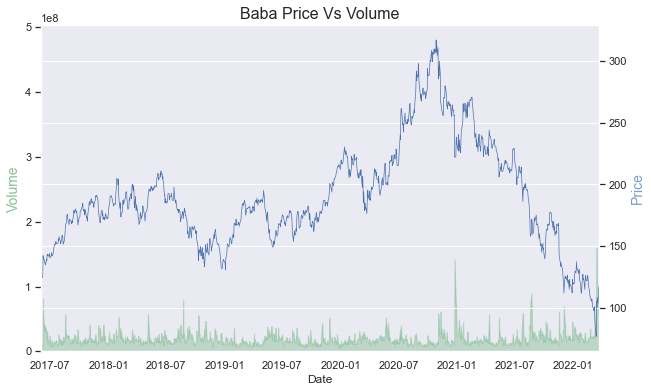

In [168]:
price_vol_plot(df_baba, 'Baba')

#### Plot 20, 50, 200 day MA with the closing prices to estimate current trend
The 200-day moving average is considered especially significant in stock trading. As long as the 50-day moving average of a stock price remains above the 200-day moving average, the stock is generally thought to be in a bullish trend. As a general guideline, if the price is above a moving average, the trend is up. If the price is below a moving average, the trend is down. However, moving averages can have different lengths (discussed shortly), so one MA may indicate an uptrend while another MA indicates a downtrend.

In [170]:
def mov_avg(df, *args, exp=False, name):
    fig, ax1 = plt.subplots(figsize=(10,6))
    
    for idx, ma in enumerate(args):
        col = f"MA_{ma}" 
        if exp == True:
            df[col] = df['Adj Close'].ewm(span=ma, adjust=False).mean()
        else:
            df[col] = df['Adj Close'].rolling(window=ma, center=False).mean()     
        sns.lineplot(x='Date', y=f"MA_{args[idx]}", data=df, ax=ax1, label=str(ma), linewidth= .7)
    ax1.set_title(name + ' Moving Average', fontsize= 14)
    sns.lineplot(x='Date', y='Adj Close', data=df, ax=ax1, linewidth= .7, linestyle='--')
    ax1.set_ylabel('Price', fontsize=14, color='b', alpha=0.7)
    ax1.set_xlim([S_DATE_DT, E_DATE_DT])
    plt.show()

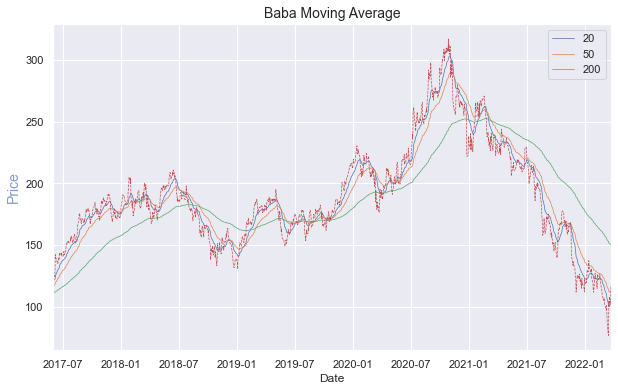

In [171]:
mov_avg(df_baba,20,50,200,exp= True,name="Baba")

#### Daily average return values

In [172]:
def avg_daily_ret(df):
    df['Daily_ret'] = df['Close'].pct_change()
    df['Pos/Neg'] = ''

    df.loc[(df['Daily_ret'] > 0), 'Pos/Neg'] = 'Above'
    df.loc[(df['Daily_ret'] < 0), 'Pos/Neg'] = 'Below'
    
    nan_value = float("NaN")
    df.replace("", nan_value, inplace=True)

    df = df.astype({"Pos/Neg":'category'})
    
    fig = plt.figure(figsize=(12, 7))
    ax1 = fig.add_subplot(131)
    g = sns.scatterplot(x="Date", y="Daily_ret", data=df, ax=ax1)
    ax1.set_title('% Change By Date', fontsize= 13)
    plt.xticks(rotation=45)

    ax2 = fig.add_subplot(132)
    g2 = sns.distplot(x=df.Daily_ret, color="red", vertical=True, ax=ax2)
    ax2.set_title('% Change KDE', fontsize= 13)
    
    ax3 = fig.add_subplot(133)
    ax3.set(yticklabels=[])
    ax3.set_title('Categorical +/-', fontsize= 13)
    
    my_list = []
    for x in range(len(df["Pos/Neg"])):
        my_list.append(x)
    arr = np.array(my_list)
    
    g3 = sns.barplot(x="Pos/Neg", y=arr, data=df, ax=ax3, ci=None)
    g.axhline(y=0, color ="black", linestyle ="--")
    g2.axhline(y=0, color ="black", linestyle ="--")
    
    plt.show()

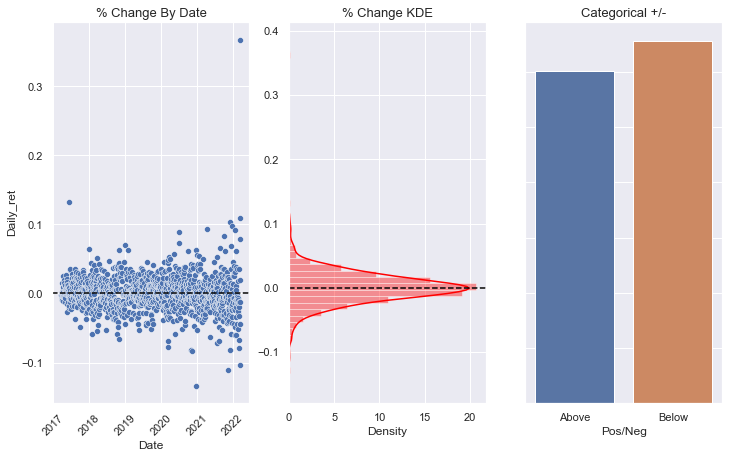

In [173]:
avg_daily_ret(df_baba)

# Bollinger Bands

So in other words…

If the price is near the upper Bollinger Band, it’s considered “expensive” because it is 2 standard deviation above the average (the 20-period moving average).

And if the is price near the lower Bollinger Band, it’s considered “cheap” because it’s 2 standard deviation below the average.

Volatility is always changing.

The markets move from a period of high volatility to low volatility (and vice versa).

If you’re a new trader, it can be difficult to identify the volatility of the markets.

So, this is where Bollinger Bands can help because it contracts when volatility is low and expands when volatility is high.

In [174]:
def bollinger(df):

    df['middle_band'] = df['Close'].rolling(window=20).mean()
    df['upper_band'] = df['middle_band'] + 1.96 * df['Close'].rolling(window=20).std()
    df['lower_band'] = df['middle_band'] - 1.96 * df['Close'].rolling(window=20).std()

    up = df[df['Close'] >= df['Open']]
    down = df[df['Close'] < df['Open']]

    fig1, ax1 = plt.subplots(figsize=(12, 7))
    width = .5
    cola = 'green'
    colb = 'red'
    colc = 'blue'
    
    # Bands
    sns.lineplot(x='Date', y='middle_band', data=df, color= cola, size=0.1, ax=ax1, linestyle='--', alpha=.7)
    sns.lineplot(x='Date', y='upper_band', data=df, color= colc, size=0.1, ax=ax1, alpha=.3)
    sns.lineplot(x='Date', y='lower_band', data=df, color= colc, size=0.1, ax=ax1, alpha=.3)
    

    # Price Increase
    plt.bar(up['Date'], up['Close']-up['Open'], width, bottom=up['Open'], color=cola, lw=0)
    plt.bar(up['Date'], up['High']-up['Close'], width, bottom=up['Close'], color=cola, lw=0)
    plt.bar(up['Date'], up['Low']-up['Open'], width, bottom=up['Open'], color=cola, lw=0)

    # Price Decrease
    plt.bar(down['Date'], down['Close']-down['Open'], width, bottom=down['Open'], color=colb, lw=0)
    plt.bar(down['Date'], down['High']-down['Open'], width, bottom=down['Open'], color=colb, lw=0)
    plt.bar(down['Date'], down['Low']-down['Close'],width,bottom=down['Close'], color=colb, lw=0)

    ax1.get_legend().remove()
    ax1.set_xlim(S_DATE_DT, E_DATE_DT)
    plt.title("Bollinger Bands",fontsize=14)
    plt.ylabel('')
    plt.show()

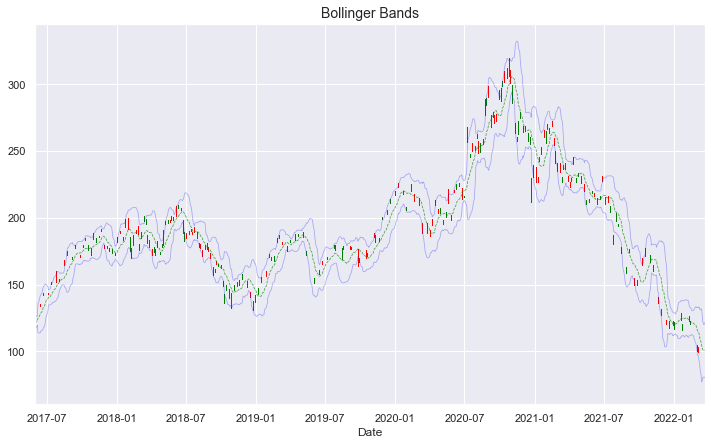

In [175]:
bollinger(df_baba)

#### Correlation Plots

In [179]:
def cor_plot(x,y):

    cor_raw = get_dataframe(fetch_list, data = 'Adj Close')
    df = cor_raw.reset_index()
    df = df.dropna()
    temp = df.set_index('Date');
    cor_df = temp.pct_change().dropna()
    
    g = sns.jointplot(x=x,y=y, data=cor_df, kind='reg', height=6)
    r, p = stats.pearsonr(cor_df[x], cor_df[y])
    g.ax_joint.annotate(f'p = {p:.2e}\nr = {r:.2f}', xy=(0.1, 0.9), xycoords='axes fraction',
                        ha='left', va='center')
    
    plt.show()

    g2 = sns.heatmap(cor_df.corr(), cmap="Blues", annot=True)
    plt.show()

In [180]:
cor_plot('df_baba','df_amc')

NameError: name 'get_dataframe' is not defined

In [ ]:
assert False, "breakpoint"